In [69]:
import nifgen
import numpy as np

In [374]:
def generate_large_normalized_waveform(
    size_gb: float = 1.6,
    output_dtype: str = 'float64', # 'int16' or 'float64'
    sample_rate: int = 88200,
    samples_per_channel_increment: int = 64 # New parameter for hardware alignment
) -> list[np.ndarray]:
    """
    Generates a large waveform of a specified size (in GB), normalized to the
    appropriate range for the given dtype (int16 or float64), and returns it
    as a list of 16 MB NumPy array chunks. Each chunk's sample count and the
    total waveform's sample count will be an integer multiple of
    samples_per_channel_increment.

    WARNING: This function will attempt to allocate a significant amount of memory
    (e.g., 1.6 GB for the default size) internally before chunking.
    Ensure your system has sufficient RAM.

    Args:
        size_gb (float): The desired total size of the waveform in gigabytes.
                         Defaults to 1.6 GB.
        output_dtype (str): The desired data type for the output array.
                            Can be 'int16' or 'float64'. Defaults to 'float64'.
        sample_rate (int): The sample rate of the audio (samples per second).
                           Used for context, as sizing is by GB.
        samples_per_channel_increment (int): The required sample increment for
                                             hardware compatibility (e.g., 64).
                                             The total samples and each chunk's
                                             samples will be a multiple of this.

    Returns:
        list[np.ndarray]: A list of NumPy arrays, where each array is a chunk
                          of the normalized waveform with the specified dtype.
                          Each chunk will be approximately 16 MB and its sample
                          count will be a multiple of the increment.
                          Returns an empty list if memory allocation is deemed
                          too risky or an invalid dtype is provided.
    """
    if output_dtype == 'float64':
        bytes_per_sample = 8  # float64 is 8 bytes
        target_dtype = np.float64
        normalization_range = 1.0 # For -1.0 to 1.0
        print(f"Generating waveform in float64 format.")
    elif output_dtype == 'int16':
        bytes_per_sample = 2  # int16 is 2 bytes
        target_dtype = np.int16
        normalization_range = 32767.0 # For -32768 to 32767 (max value for int16)
        print(f"Generating waveform in int16 format.")
    else:
        print(f"Error: Invalid output_dtype '{output_dtype}'. Must be 'int16' or 'float64'.")
        return [] # Return empty list for invalid dtype

    total_bytes = int(size_gb * 1024 * 1024 * 1024)
    num_samples_raw = total_bytes // bytes_per_sample

    # Ensure total number of samples is a multiple of the increment
    # This handles cases where the requested GB size doesn't perfectly align
    num_samples = (num_samples_raw + samples_per_channel_increment - 1) // samples_per_channel_increment * samples_per_channel_increment

    print(f"Attempting to generate a waveform of {size_gb} GB (approx).")
    print(f"Adjusted total samples to {num_samples} to be a multiple of {samples_per_channel_increment}.")
    print(f"This will require approximately {num_samples * bytes_per_sample / (1024**3):.2f} GB of RAM.")

    if num_samples > 1_000_000_000:
        print("Warning: This will create an extremely large array. Proceed with caution.")

    try:
        # Generate initial random samples between -1 and 1
        raw_waveform = np.random.uniform(-1, 1, num_samples)

        # Normalize and cast based on the target dtype
        if output_dtype == 'float64':
            waveform = raw_waveform.astype(target_dtype)
            # No further normalization needed as uniform(-1,1) already covers the range
        elif output_dtype == 'int16':
            # Scale to the int16 range and then cast
            waveform = (raw_waveform * normalization_range).astype(target_dtype)
            # np.clip(waveform, np.iinfo(np.int16).min, np.iinfo(np.int16).max, out=waveform)

        # --- Manual Chunking logic to ensure all chunks are aligned ---
        chunk_size_mb = 16
        chunk_size_bytes = chunk_size_mb * 1024 * 1024
        chunk_size_samples_raw = chunk_size_bytes // bytes_per_sample

        # Ensure the desired chunk size for each segment is a multiple of the increment
        # This will be the size of all full chunks
        aligned_chunk_size_samples = (chunk_size_samples_raw + samples_per_channel_increment - 1) // samples_per_channel_increment * samples_per_channel_increment

        waveform_chunks = []
        start_index = 0
        while start_index < num_samples:
            end_index = min(start_index + aligned_chunk_size_samples, num_samples)
            current_chunk = waveform[start_index:end_index]

            # The last chunk might be smaller than aligned_chunk_size_samples,
            # but its size will still be a multiple of samples_per_channel_increment
            # because num_samples itself is a multiple.
            if current_chunk.shape[0] % samples_per_channel_increment != 0:
                # This case should ideally not be reached if num_samples is correctly aligned
                # and aligned_chunk_size_samples is correctly aligned.
                # If it does, it indicates a fundamental issue in the alignment logic.
                print(f"Error: A chunk of size {current_chunk.shape[0]} was generated which is not a multiple of the increment {samples_per_channel_increment}. This should not happen with current logic.")

            waveform_chunks.append(current_chunk)
            start_index = end_index

        print("Waveform generated, normalized, and chunked successfully.")
        print(f"Total samples generated: {num_samples}")
        return waveform_chunks
    except MemoryError:
        print("Error: Not enough memory to create the waveform. Please reduce size_gb or free up RAM.")
        return [] # Return empty list on error
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [] # Return empty list on error

# Example usage for float64 (will attempt to allocate 1.6 GB and chunk)
waveform_chunks_float64 = generate_large_normalized_waveform(3.2, output_dtype='float64', samples_per_channel_increment=64)
if waveform_chunks_float64:
    print(f"Generated {len(waveform_chunks_float64)} float64 chunks.")
    for i, chunk in enumerate(waveform_chunks_float64[:3]): # Print info for first 3 chunks
        print(f"  Chunk {i+1} shape: {chunk.shape}, Dtype: {chunk.dtype}, Size (MB): {chunk.nbytes / (1024*1024):.2f}")
        print(f"  Chunk {i+1} samples % {64} = {chunk.shape[0] % 64}") # Verify divisibility
    if len(waveform_chunks_float64) > 3:
        print("  ...")

# Example usage for int16 (will attempt to allocate 1.6 GB and chunk)
# waveform_chunks_int16 = generate_large_normalized_waveform(1.6, output_dtype='int16', samples_per_channel_increment=64)
# if waveform_chunks_int16:
#     print(f"Generated {len(waveform_chunks_int16)} int16 chunks.")
#     for i, chunk in enumerate(waveform_chunks_int16[:3]): # Print info for first 3 chunks
#         print(f"  Chunk {i+1} shape: {chunk.shape}, Dtype: {chunk.dtype}, Size (MB): {chunk.nbytes / (1024*1024):.2f}")
#         print(f"  Chunk {i+1} samples % {64} = {chunk.shape[0] % 64}") # Verify divisibility
#     if len(waveform_chunks_int16) > 3:
#         print("  ...")

Generating waveform in float64 format.
Attempting to generate a waveform of 3.2 GB (approx).
Adjusted total samples to 429496768 to be a multiple of 64.
This will require approximately 3.20 GB of RAM.
Waveform generated, normalized, and chunked successfully.
Total samples generated: 429496768
Generated 205 float64 chunks.
  Chunk 1 shape: (2097152,), Dtype: float64, Size (MB): 16.00
  Chunk 1 samples % 64 = 0
  Chunk 2 shape: (2097152,), Dtype: float64, Size (MB): 16.00
  Chunk 2 samples % 64 = 0
  Chunk 3 shape: (2097152,), Dtype: float64, Size (MB): 16.00
  Chunk 3 samples % 64 = 0
  ...


In [ ]:
import numpy as np

def generate_large_normalized_waveform(
    size_gb: float = 3.2,
    output_dtype: str = 'float64', # 'int16' or 'float64'
    sample_rate: int = 100000,
    samples_per_channel_increment: int = 64, # New parameter for hardware alignment
    base_frequency: float = 10000.0, # New parameter for waveform frequency
    wave_segment_duration_seconds: float = 10.0 # New parameter: duration of each sine/square/sawtooth part
) -> list[np.ndarray]:
    """
    Generates a large waveform of a specified size (in GB), normalized to the
    appropriate range for the given dtype (int16 or float64), and returns it
    as a list of 16 MB NumPy array chunks. Each chunk's sample count and the
    total waveform's sample count will be an integer multiple of
    samples_per_channel_increment. The waveform cycles through sine, square,
    and sawtooth wave segments.

    WARNING: This function will attempt to allocate a significant amount of memory
    (e.g., 1.6 GB for the default size) internally before chunking.
    Ensure your system has sufficient RAM.

    Args:
        size_gb (float): The desired total size of the waveform in gigabytes.
                         Defaults to 1.6 GB.
        output_dtype (str): The desired data type for the output array.
                            Can be 'int16' or 'float64'. Defaults to 'float64'.
        sample_rate (int): The sample rate of the audio (samples per second).
                           Used for context, as sizing is by GB.
        samples_per_channel_increment (int): The required sample increment for
                                             hardware compatibility (e.g., 64).
                                             The total samples and each chunk's
                                             samples will be a multiple of this.
        base_frequency (float): The base frequency for the generated sine, square,
                                and sawtooth waves.
        wave_segment_duration_seconds (float): The duration in seconds for each
                                               individual sine, square, or sawtooth
                                               segment within a cycle.

    Returns:
        list[np.ndarray]: A list of NumPy arrays, where each array is a chunk
                          of the normalized waveform with the specified dtype.
                          Each chunk will be approximately 16 MB and its sample
                          count will be a multiple of the increment.
                          Returns an empty list if memory allocation is deemed
                          too risky or an invalid dtype is provided.
    """
    if output_dtype == 'float64':
        bytes_per_sample = 8  # float64 is 8 bytes
        target_dtype = np.float64
        normalization_range = 1.0 # For -1.0 to 1.0
        print(f"Generating waveform in float64 format.")
    elif output_dtype == 'int16':
        bytes_per_sample = 2  # int16 is 2 bytes
        target_dtype = np.int16
        normalization_range = 32767.0 # For -32768 to 32767 (max value for int16)
        print(f"Generating waveform in int16 format.")
    else:
        print(f"Error: Invalid output_dtype '{output_dtype}'. Must be 'int16' or 'float64'.")
        return [] # Return empty list for invalid dtype

    total_bytes = int(size_gb * 1024 * 1024 * 1024)
    num_samples_raw = total_bytes // bytes_per_sample

    # Ensure total number of samples is a multiple of the increment
    num_samples = (num_samples_raw + samples_per_channel_increment - 1) // samples_per_channel_increment * samples_per_channel_increment

    print(f"Attempting to generate a waveform of {size_gb} GB (approx).")
    print(f"Adjusted total samples to {num_samples} to be a multiple of {samples_per_channel_increment}.")
    print(f"This will require approximately {num_samples * bytes_per_sample / (1024**3):.2f} GB of RAM.")

    if num_samples > 1_000_000_000:
        print("Warning: This will create an extremely large array. Proceed with caution.")

    try:
        # --- Waveform Generation Logic for Cycling ---
        # Calculate samples for each individual wave type segment within a cycle
        samples_per_individual_wave_segment_raw = int(wave_segment_duration_seconds * sample_rate)
        # Ensure this segment length is also a multiple of the increment
        samples_per_individual_wave_segment = (
            samples_per_individual_wave_segment_raw + samples_per_channel_increment - 1
        ) // samples_per_channel_increment * samples_per_channel_increment

        # Generate time vector for a single segment
        t_segment = np.linspace(0, samples_per_individual_wave_segment / sample_rate, samples_per_individual_wave_segment, endpoint=False)

        # Generate base waveforms for one segment duration
        sine_base = np.sin(2 * np.pi * base_frequency * t_segment)
        square_base = np.sign(np.sin(2 * np.pi * base_frequency * t_segment))
        square_base[square_base == 0] = 1 # Handle zero crossings
        sawtooth_base = 2 * (t_segment * base_frequency - np.floor(t_segment * base_frequency + 0.5))

        # Concatenate to form one full cycle
        full_cycle_waveform = np.concatenate((sine_base, square_base, sawtooth_base))

        # Calculate how many full cycles fit into the total num_samples
        num_full_cycles = num_samples // full_cycle_waveform.shape[0]
        remaining_samples_after_full_cycles = num_samples % full_cycle_waveform.shape[0]

        # Create the raw_waveform by tiling the full cycle
        raw_waveform_combined = np.tile(full_cycle_waveform, num_full_cycles)

        # Append the beginning of the full cycle for the remaining samples
        if remaining_samples_after_full_cycles > 0:
            raw_waveform_combined = np.concatenate((raw_waveform_combined, full_cycle_waveform[:remaining_samples_after_full_cycles]))

        # Ensure the final waveform exactly matches num_samples (should be true if logic is correct)
        raw_waveform = raw_waveform_combined[:num_samples]


        # Normalize and cast based on the target dtype
        if output_dtype == 'float64':
            waveform = raw_waveform.astype(target_dtype)
        elif output_dtype == 'int16':
            waveform = (raw_waveform * normalization_range).astype(target_dtype)

        # --- Manual Chunking logic to ensure all chunks are aligned ---
        chunk_size_mb = 16
        chunk_size_bytes = chunk_size_mb * 1024 * 1024
        chunk_size_samples_raw = chunk_size_bytes // bytes_per_sample

        # Ensure the desired chunk size for each segment is a multiple of the increment
        aligned_chunk_size_samples = (chunk_size_samples_raw + samples_per_channel_increment - 1) // samples_per_channel_increment * samples_per_channel_increment

        waveform_chunks = []
        start_index = 0
        while start_index < num_samples:
            end_index = min(start_index + aligned_chunk_size_samples, num_samples)
            current_chunk = waveform[start_index:end_index]

            # Verify chunk alignment (should pass if num_samples and aligned_chunk_size_samples are correct)
            if current_chunk.shape[0] % samples_per_channel_increment != 0:
                print(f"Error: A chunk of size {current_chunk.shape[0]} was generated which is not a multiple of the increment {samples_per_channel_increment}. This should not happen with current logic.")

            waveform_chunks.append(current_chunk)
            start_index = end_index

        print("Waveform generated, normalized, and chunked successfully.")
        print(f"Total samples generated: {num_samples}")
        print(f"Each wave segment (sine/square/sawtooth) is approx. {wave_segment_duration_seconds} seconds long.")
        print(f"Number of full waveform cycles: {num_full_cycles}")
        return waveform_chunks
    except MemoryError:
        print("Error: Not enough memory to create the waveform. Please reduce size_gb or free up RAM.")
        return [] # Return empty list on error
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [] # Return empty list on error

# Example usage for float64 (will attempt to allocate 1.6 GB and chunk)
waveform_chunks_float64 = generate_large_normalized_waveform(1.6, output_dtype='float64', samples_per_channel_increment=64, wave_segment_duration_seconds=50.0)
if waveform_chunks_float64:
    print(f"Generated {len(waveform_chunks_float64)} float64 chunks.")
    for i, chunk in enumerate(waveform_chunks_float64[:3]): # Print info for first 3 chunks
        print(f"  Chunk {i+1} shape: {chunk.shape}, Dtype: {chunk.dtype}, Size (MB): {chunk.nbytes / (1024*1024):.2f}")
        print(f"  Chunk {i+1} samples % {64} = {chunk.shape[0] % 64}") # Verify divisibility
    if len(waveform_chunks_float64) > 3:
        print("  ...")

# Example usage for int16 (will attempt to allocate 1.6 GB and chunk)
# waveform_chunks_int16 = generate_large_normalized_waveform(1.6, output_dtype='int16', samples_per_channel_increment=64, wave_segment_duration_seconds=5.0)
# if waveform_chunks_int16:
#     print(f"Generated {len(waveform_chunks_int16)} int16 chunks.")
#     for i, chunk in enumerate(waveform_chunks_int16[:3]): # Print info for first 3 chunks
#         print(f"  Chunk {i+1} shape: {chunk.shape}, Dtype: {chunk.dtype}, Size (MB): {chunk.nbytes / (1024*1024):.2f}")
#         print(f"  Chunk {i+1} samples % {64} = {chunk.shape[0] % 64}") # Verify divisibility
#     if len(waveform_chunks_int16) > 3:
#         print("  ...")


Generating waveform in float64 format.
Attempting to generate a waveform of 1.6 GB (approx).
Adjusted total samples to 214748416 to be a multiple of 64.
This will require approximately 1.60 GB of RAM.
An unexpected error occurred: slice indices must be integers or None or have an __index__ method


In [393]:
type(waveform_chunks_float64)

list

In [392]:
import numpy as np

# Assume this is your array
arr = np.arange(112_090_304, dtype=np.float64)

# Max allocation space in bytes
max_mem = 160 * 1024 * 1024  # 160 MiB = 167_772_160 bytes
target_chunk = max_mem // 10  # Ideal chunk size ~16.7 MiB

# Find best chunk size that evenly divides max_mem
for chunk_size in range(target_chunk, 0, -1):
    if max_mem % chunk_size == 0:
        break  # Found the best chunk size

# Now compute how many elements that is
bytes_per_element = arr.itemsize
elements_per_chunk = chunk_size // bytes_per_element

print(f"Max mem: {max_mem} bytes")
print(f"Chunk size: {chunk_size} bytes")
print(f"Elements per chunk: {elements_per_chunk}")
print(f"Total chunks needed: {int(np.ceil(arr.nbytes / chunk_size))}")


Max mem: 167772160 bytes
Chunk size: 16777216 bytes
Elements per chunk: 2097152
Total chunks needed: 54


In [385]:
chunk_size = 16 * 1024 * 1024
import time
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.ARB
    session.arb_sample_rate = 10_000_000
    #160 MB allocation
    waveform_handle = session.allocate_waveform(83886080)
    session.streaming_waveform_handle = waveform_handle
    print(session.waveform_quantum)
    print(session.streaming_space_available_in_waveform)

    # Write 10, 16MB chunks
    for i in range(10):
        session.write_waveform(waveform_handle, waveform_chunks_float64[i])
    # Initiate
    session.initiate()

    print(session.streaming_space_available_in_waveform)
    
    # Write the rest of the chunks
    for i in range(10, len(waveform_chunks_float64)):
        print(f'Writing Chunk {i}')
        print(session.streaming_space_available_in_waveform)
        session.write_waveform(waveform_handle, waveform_chunks_float64[i])
        print(session.streaming_space_available_in_waveform)




4
83886080
62917568
Writing Chunk 10
62921856
61590080
Writing Chunk 11
61592256
60200768
Writing Chunk 12
60203200
58809344
Writing Chunk 13
58812224
57413504
Writing Chunk 14
57415680
56020992
Writing Chunk 15
56023360
54629504
Writing Chunk 16
54632512
53238080
Writing Chunk 17
53242496
51852800
Writing Chunk 18
51855040
50463616
Writing Chunk 19
50465920
49073984
Writing Chunk 20
49077568
47680768
Writing Chunk 21
47683136
46288256
Writing Chunk 22
46290560
44896256
Writing Chunk 23
44899904
43503104
Writing Chunk 24
43505536
42111424
Writing Chunk 25
42113728
40716160
Writing Chunk 26
40723392
39295488
Writing Chunk 27
39297792
37903296
Writing Chunk 28
37905664
36515072
Writing Chunk 29
36517312
35108224
Writing Chunk 30
35112256
33712704
Writing Chunk 31
33715136
32323136
Writing Chunk 32
32325504
30931200
Writing Chunk 33
30933568
29541632
Writing Chunk 34
29546496
28157248
Writing Chunk 35
28159680
26762304
Writing Chunk 36
26764672
25367552
Writing Chunk 37
25371072
23980736


### Arbitrary Sequence Streaming

In [373]:
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 100_000_000
    session.streaming_write_timeout = 30.0

    # Get handles for location of waveform in memory
    square_handle = session._create_waveform_f64_numpy(square_wave)

    # Create waveform handle array and loop counts for sequence
    waveform_handle_array = []
    loop_counts = []

    waveform_handle_array.append(square_handle)
    loop_counts.append(63)
    

    # Load waveform handle array and loop counts to make a sequence
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)

    # Configuring the sequence with the sequence handle
    session.configure_arb_sequence(sequence_handle, 1, 0)

    # Add a trigger to start the next waveform
    session.start_trigger_type                = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge   = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode                      = nifgen.TriggerMode.STEPPED

    # Initiate session
    session.initiate()
    time.sleep(10)

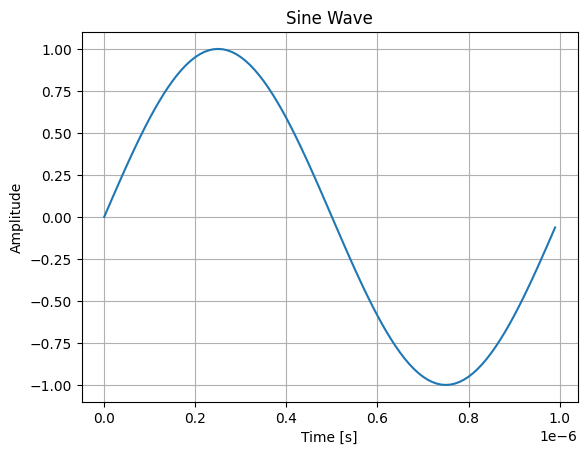

In [361]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 1e6  # Hz
sampling_rate = 100_000_000  # Samples per second
duration = 1e-6  # Seconds

# Time array
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Sine wave
sine_wave = np.sin(2 * np.pi * frequency * t).astype(np.float64)

# Plot
plt.plot(t, sine_wave)
plt.title("Sine Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


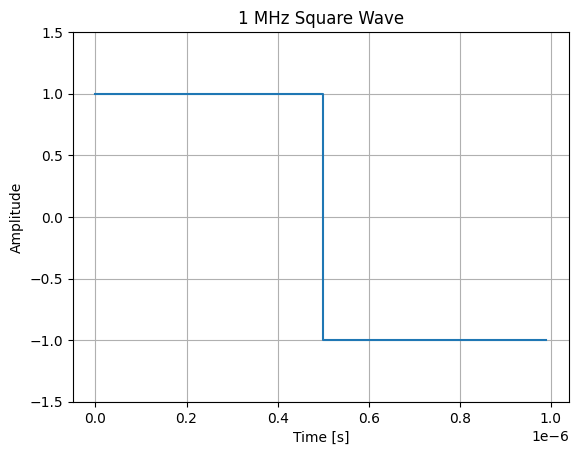

In [363]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 1e6         # Hz
sampling_rate = 100_000_000  # Samples per second
duration = 1e-6         # Seconds

# Time array
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Square wave: +1 when sine ≥ 0, –1 when sine < 0
square_wave = np.where(
    np.sin(2 * np.pi * frequency * t) >= 0,
    1.0,
    -1.0
).astype(np.float64)

# Plot
plt.plot(t, square_wave, drawstyle='steps-pre')
plt.title("1 MHz Square Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.show()
